In [30]:
#!/usr/bin/env python
# coding=utf-8
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.

#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None
exp_path = Path.cwd().resolve() # experiment path
# visible GPUs
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"


from matplotlib import pyplot as plt

import argparse
import yaml
import hashlib
import itertools
import logging
import math
# import warnings
from pathlib import Path
from typing import Optional

import accelerate
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed
from huggingface_hub import HfFolder, Repository, create_repo, whoami
from packaging import version
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig
from datasets import load_dataset
import diffusers
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    DiffusionPipeline,
    DPMSolverMultistepScheduler,
    UNet2DConditionModel,
    DDIMScheduler,
)
import random
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available


if is_wandb_available():
    import wandb

# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
check_min_version("0.15.0.dev0")

logger = get_logger(__name__)


def log_validation(text_encoder, tokenizer, unet, vae, args, accelerator, weight_dtype, epoch):
    logger.info(
        f"Running validation... \n Generating {args.num_validation_images} images with prompt:"
        f" {args.validation_prompt}."
    )
    # create pipeline (note: unet and vae are loaded again in float32)
    pipeline = DiffusionPipeline.from_pretrained(
        args.pretrained_model_name_or_path,
        text_encoder=accelerator.unwrap_model(text_encoder),
        tokenizer=tokenizer,
        unet=accelerator.unwrap_model(unet),
        vae=vae,
        revision=args.revision,
        torch_dtype=weight_dtype,
        safety_checker=None,
    )
    pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)
    pipeline = pipeline.to(accelerator.device)
    pipeline.set_progress_bar_config(disable=True)

    # run inference
    generator = None if args.seed is None else torch.Generator(device=accelerator.device).manual_seed(args.seed)
    images = []
    for _ in range(args.num_validation_images):
        with torch.autocast("cuda"):
            image = pipeline(args.validation_prompt, num_inference_steps=25, generator=generator).images[0]
        images.append(image)

    for tracker in accelerator.trackers:
        if tracker.name == "tensorboard":
            np_images = np.stack([np.asarray(img) for img in images])
            tracker.writer.add_images("validation", np_images, epoch, dataformats="NHWC")
        if tracker.name == "wandb":
            tracker.log(
                {
                    "validation": [
                        wandb.Image(image, caption=f"{i}: {args.validation_prompt}") for i, image in enumerate(images)
                    ]
                }
            )

    del pipeline
    torch.cuda.empty_cache()


def import_model_class_from_model_name_or_path(pretrained_model_name_or_path: str, revision: str):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path,
        subfolder="text_encoder",
        revision=revision,
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "RobertaSeriesModelWithTransformation":
        from diffusers.pipelines.alt_diffusion.modeling_roberta_series import RobertaSeriesModelWithTransformation

        return RobertaSeriesModelWithTransformation
    else:
        raise ValueError(f"{model_class} is not supported.")


def collate_fn(examples, with_prior_preservation=False):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = torch.cat(input_ids, dim=0)

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch


class PromptDataset(Dataset):
    """A simple dataset to prepare the prompts to generate class images on multiple GPUs.
    The get item trturns example dictionaty with the prompt and the index of the example.
    """

    def __init__(self, prompt, num_samples):
        """init with promt and number of samples

        Args:
            prompt (str): text prompt
            num_samples (int): num of samples
        """
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        instance_data_root,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt
        self._length = self.num_instance_images

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms_resize_and_crop = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
            ]
        )

        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        instance_image = self.image_transforms_resize_and_crop(instance_image)

        example["PIL_images"] = instance_image
        example["instance_images"] = self.image_transforms(instance_image)

        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            class_image = self.image_transforms_resize_and_crop(class_image)
            example["class_images"] = self.image_transforms(class_image)
            example["class_PIL_images"] = class_image
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example

def prepare_mask_and_masked_image(image, mask):
    image = np.array(image.convert("RGB"))
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image).to(dtype=torch.float32) / 127.5 - 1.0

    mask = np.array(mask.convert("L"))
    mask = mask.astype(np.float32) / 255.0
    mask = mask[None, None]
    mask[mask < 0.5] = 0
    mask[mask >= 0.5] = 1
    mask = torch.from_numpy(mask)

    masked_image = image * (mask < 0.5)

    return mask, masked_image

# generate random masks
def random_mask(im_shape, ratio=1, mask_full_image=False):
    mask = Image.new("L", im_shape, 0)
    draw = ImageDraw.Draw(mask)
    size = (random.randint(0, int(im_shape[0] * ratio)), random.randint(0, int(im_shape[1] * ratio)))
    # use this to always mask the whole image
    if mask_full_image:
        size = (int(im_shape[0] * ratio), int(im_shape[1] * ratio))
    limits = (im_shape[0] - size[0] // 2, im_shape[1] - size[1] // 2)
    center = (random.randint(size[0] // 2, limits[0]), random.randint(size[1] // 2, limits[1]))
    draw_type = random.randint(0, 1)
    if draw_type == 0 or mask_full_image:
        draw.rectangle(
            (center[0] - size[0] // 2, center[1] - size[1] // 2, center[0] + size[0] // 2, center[1] + size[1] // 2),
            fill=255,
        )
    else:
        draw.ellipse(
            (center[0] - size[0] // 2, center[1] - size[1] // 2, center[0] + size[0] // 2, center[1] + size[1] // 2),
            fill=255,
        )

    return mask


def get_full_repo_name(model_id: str, organization: Optional[str] = None, token: Optional[str] = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"



In [31]:
# read and set config file
config_path = 'config_file.yaml' # configuration file path (beter to call it from the args parser)
with open(config_path) as file: # expects the config file to be in the same directory
    config = yaml.load(file, Loader=yaml.FullLoader)
args = argparse.Namespace(**config) # parse the config file
args.instance_prompt = 'mammogram' # for debugging only dreambooth

logging_dir = Path(args.output_dir, args.logging_dir) # path for logging

accelerator_project_config = ProjectConfiguration(total_limit=args.checkpoints_total_limit)
accelerator = Accelerator( # start accelerator
    gradient_accumulation_steps=args.gradient_accumulation_steps,
    mixed_precision=args.mixed_precision, 
    log_with=args.report_to, # logger (tb or wandb)
    logging_dir=logging_dir, # defined above
    project_config=accelerator_project_config, # project config defined above
)

if args.report_to == "wandb":
    if not is_wandb_available():
        raise ImportError("Make sure to install wandb if you want to use it for logging during training.")

# Currently, it's not possible to do gradient accumulation when training two models with accelerate.accumulate
# This will be enabled soon in accelerate. For now, we don't allow gradient accumulation when training two models.
# TODO (patil-suraj): Remove this check when gradient accumulation with two models is enabled in accelerate.
if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
    raise ValueError(
        "Gradient accumulation is not supported when training the text encoder in distributed training. "
        "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
    )

# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger.info(accelerator.state, main_process_only=False)
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if args.seed is not None:
    set_seed(args.seed)

# Generate class images if prior preservation is enabled.
if args.with_prior_preservation:
    class_images_dir = Path(args.class_data_dir) # get path of class images
    if not class_images_dir.exists(): # create folder if not exists
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir())) # count how many images there are

    if cur_class_images < args.num_class_images: # if there are less images than needed
        # define dtype for prior generation
        torch_dtype = torch.float16 if accelerator.device.type == "cuda" else torch.float32
        if args.prior_generation_precision == "fp32":
            torch_dtype = torch.float32
        elif args.prior_generation_precision == "fp16":
            torch_dtype = torch.float16
        elif args.prior_generation_precision == "bf16":
            torch_dtype = torch.bfloat16
        pipeline = DiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path, # from same pretrained model as main model
            vae=AutoencoderKL.from_pretrained(
                args.pretrained_vae_name_or_path or args.pretrained_model_name_or_path,
                subfolder=None if args.pretrained_vae_name_or_path else "vae",
                revision=None if args.pretrained_vae_name_or_path else args.revision,
                torch_dtype=torch_dtype
            ), 
            torch_dtype=torch_dtype,
            safety_checker=None, # no safety checker
            revision=args.revision, # The specific model version to use
        )
        pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = args.num_class_images - cur_class_images # number of images still needed
        logger.info(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(args.class_prompt, num_new_images) # define prompt dataset, returns prompt and index as item
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=args.sample_batch_size)

        sample_dataloader = accelerator.prepare(sample_dataloader) # dataloader for accelerator
        pipeline.to(accelerator.device) # send pipeline to accelerator device

        for example in tqdm(sample_dataloader, desc="Generating class images", disable=not accelerator.is_local_main_process):
            images = pipeline(example["prompt"], num_inference_steps=20).images # generate image(s) from prompt

            for i, image in enumerate(images): # for each image in the batch
                hash_image = hashlib.sha1(image.tobytes()).hexdigest() # create hash as unique identifier
                image_filename = class_images_dir / f"{example['index'][i] + cur_class_images}-{hash_image}.jpg"
                image.save(image_filename)

        del pipeline # free memory when done
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# # Handle the repository creation
# if accelerator.is_main_process:
#     if args.push_to_hub:
#         if args.hub_model_id is None:
#             repo_name = get_full_repo_name(Path(args.output_dir).name, token=args.hub_token)
#         else:
#             repo_name = args.hub_model_id
#         create_repo(repo_name, exist_ok=True, token=args.hub_token)
#         repo = Repository(args.output_dir, clone_from=repo_name, token=args.hub_token)

#         with open(os.path.join(args.output_dir, ".gitignore"), "w+") as gitignore:
#             if "step_*" not in gitignore:
#                 gitignore.write("step_*\n")
#             if "epoch_*" not in gitignore:
#                 gitignore.write("epoch_*\n")
#     elif args.output_dir is not None: # create output directory if it doesn't exist
#         os.makedirs(args.output_dir, exist_ok=True)

# Load the tokenizer
if args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(args.tokenizer_name, revision=args.revision, use_fast=False)
elif args.pretrained_model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(
        args.pretrained_model_name_or_path,
        subfolder="tokenizer",
        revision=args.revision,
        use_fast=False,
    )

# import correct text encoder class: only ROBERTA or CLIP
text_encoder_cls = import_model_class_from_model_name_or_path(args.pretrained_model_name_or_path, args.revision)

# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model_name_or_path, subfolder="scheduler")
text_encoder = text_encoder_cls.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="text_encoder", revision=args.revision
)

#vae = AutoencoderKL.from_pretrained(args.pretrained_model_name_or_path, subfolder="vae", revision=args.revision)
vae=AutoencoderKL.from_pretrained(
                args.pretrained_vae_name_or_path or args.pretrained_model_name_or_path,
                subfolder=None if args.pretrained_vae_name_or_path else "vae",
                revision=None if args.pretrained_vae_name_or_path else args.revision,
            )

unet = UNet2DConditionModel.from_pretrained(
    args.pretrained_model_name_or_path, subfolder="unet", revision=args.revision
)

# `accelerate` 0.16.0 will have better support for customized saving
if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
    # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
    def save_model_hook(models, weights, output_dir):
        for model in models:
            sub_dir = "unet" if type(model) == type(unet) else "text_encoder"
            model.save_pretrained(os.path.join(output_dir, sub_dir))

            # make sure to pop weight so that corresponding model is not saved again
            weights.pop()

    def load_model_hook(models, input_dir):
        while len(models) > 0:
            # pop models so that they are not loaded again
            model = models.pop()

            if type(model) == type(text_encoder):
                # load transformers style into model
                load_model = text_encoder_cls.from_pretrained(input_dir, subfolder="text_encoder")
                model.config = load_model.config
            else:
                # load diffusers style into model
                load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
                model.register_to_config(**load_model.config)

            model.load_state_dict(load_model.state_dict())
            del load_model

    accelerator.register_save_state_pre_hook(save_model_hook)
    accelerator.register_load_state_pre_hook(load_model_hook)

# freeze models
vae.requires_grad_(False)
if not args.train_text_encoder: # freeze text encoder if not training it
    text_encoder.requires_grad_(False)

# optimize GPU memory usage and more
if args.enable_xformers_memory_efficient_attention:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
        vae.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")
if args.gradient_checkpointing:
    unet.enable_gradient_checkpointing()
    if args.train_text_encoder:
        text_encoder.gradient_checkpointing_enable()

# Check that all trainable models are in full precision
low_precision_error_string = (
    "Please make sure to always have all model weights in full float32 precision when starting training - even if"
    " doing mixed precision training. copy of the weights should still be float32."
)
if accelerator.unwrap_model(unet).dtype != torch.float32:
    raise ValueError(
        f"Unet loaded as datatype {accelerator.unwrap_model(unet).dtype}. {low_precision_error_string}"
    )
if args.train_text_encoder and accelerator.unwrap_model(text_encoder).dtype != torch.float32:
    raise ValueError(
        f"Text encoder loaded as datatype {accelerator.unwrap_model(text_encoder).dtype}."
        f" {low_precision_error_string}"
    )

# Enable TF32 for faster training on Ampere GPUs,
# cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
if args.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True
# scaling learning rate by number of GPUs and gradient accumulation steps
if args.scale_lr:
    args.learning_rate = (
        args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
    )

# Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs # bits and bytes-enebled
# This changes the optimizer class
if args.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "To use 8-bit Adam, please install the bitsandbytes library: `pip install bitsandbytes`."
        )

    optimizer_class = bnb.optim.AdamW8bit
else:
    optimizer_class = torch.optim.AdamW

# Optimizer creation
params_to_optimize = ( # unet and text encoder or une only
    itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
)
optimizer = optimizer_class(
    params_to_optimize,
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)


/home/ricardo/miniconda3/envs/dreambooth_light/lib/python3.9/site-packages/accelerate/accelerator.py:243: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
05/09/2023 14:22:52 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'variance_type', 'dynamic_thresholding_ratio', 'prediction_type', 'clip_sample_range', 'thresholding', 'sample_max_value'} was not found in config. Values will be initialized to default values.


OSError: There was a specific connection error when trying to load runwayml/stable-diffusion-v1-5:
502 Server Error: Bad Gateway for url: https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/fp16/vae/diffusion_pytorch_model.bin

In [32]:
train_dataset = DreamBoothDataset(
    instance_data_root=args.instance_data_dir,
    instance_prompt=args.instance_prompt,
    class_data_root=args.class_data_dir if args.with_prior_preservation else None,
    class_prompt=args.class_prompt,
    tokenizer=tokenizer,
    size=args.resolution,
    center_crop=args.center_crop,
)

def collate_fn(examples):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if args.with_prior_preservation:
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]
        pior_pil = [example["class_PIL_images"] for example in examples]

    masks = []
    masked_images = []
    for example in examples:
        pil_image = example["PIL_images"]
        # generate a random mask
        mask = random_mask(pil_image.size, 1, False)
        # prepare mask and masked image
        mask, masked_image = prepare_mask_and_masked_image(pil_image, mask)

        masks.append(mask)
        masked_images.append(masked_image)

    if args.with_prior_preservation:
        for pil_image in pior_pil:
            # generate a random mask
            mask = random_mask(pil_image.size, 1, False)
            # prepare mask and masked image
            mask, masked_image = prepare_mask_and_masked_image(pil_image, mask)

            masks.append(mask)
            masked_images.append(masked_image)

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad({"input_ids": input_ids}, padding=True, return_tensors="pt").input_ids
    masks = torch.stack(masks)
    masked_images = torch.stack(masked_images)
    batch = {"input_ids": input_ids, "pixel_values": pixel_values, "masks": masks, "masked_images": masked_images}
    return batch

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
)


### Analyze the dataloader output

In [33]:
# give an example from the dataloader
batch = next(iter(train_dataloader))
print(f'These are the batch keys: {batch.keys()}')

These are the batch keys: dict_keys(['input_ids', 'pixel_values', 'masks', 'masked_images'])


(512, 512, 3)


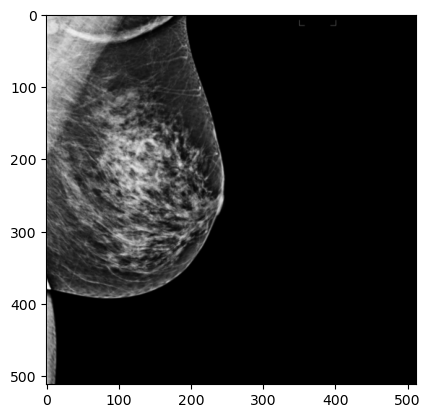

In [51]:
# get pixel values
pixel_values = batch["pixel_values"]
im = pixel_values[0].permute(1, 2, 0).numpy()
# send to 0 to 1
im = (im + 1)/2
print(im.shape)
# show image
plt.imshow(im, cmap='gray')

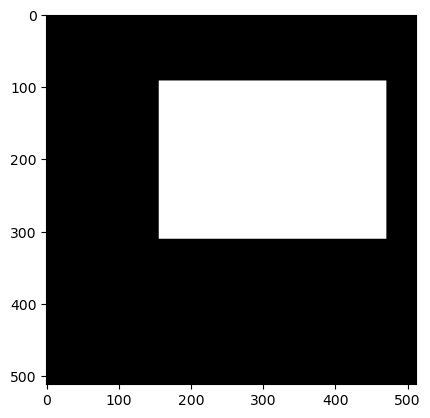

In [70]:
# get mask
masks = batch["masks"]
mask_one = masks[11,0,0]
# plot mask
plt.figure()
plt.imshow(mask_one, cmap='gray')

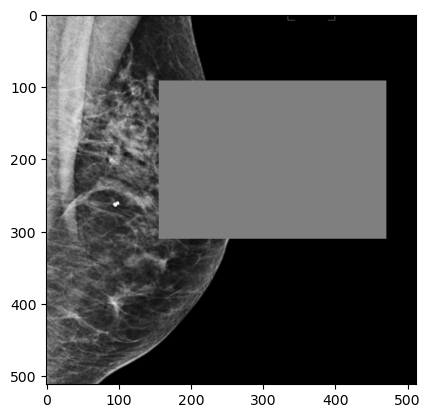

In [75]:
# get masked image
masked_images = batch["masked_images"]
masked_image_one = masked_images[11,0].permute(1, 2, 0).numpy()
# send to 0 to 1
masked_image_one = (masked_image_one + 1)/2
# plot masked image
plt.figure()
plt.imshow(masked_image_one, cmap='gray')


### Analyze the mask

In [102]:
pixel_values.size()

torch.Size([16, 3, 512, 512])

In [111]:
pixel_values = batch["pixel_values"]
mask = Image.new("L", pixel_values[0,0].shape, 0)
draw = ImageDraw.Draw(mask)
draw

### Analyze the training loop

torch.Size([16, 1, 1, 512, 512])
torch.Size([16, 1, 1, 64, 64])
torch.Size([16, 1, 64, 64])


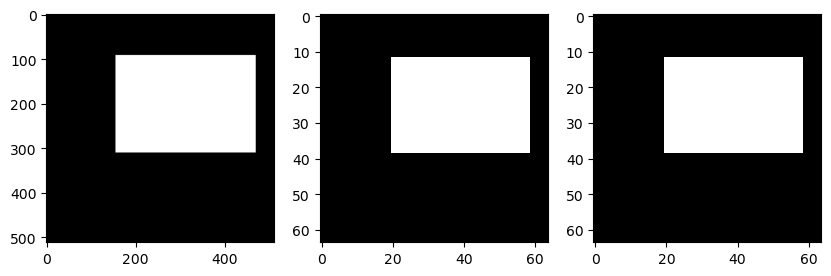

In [89]:
# masks are reshaped into the latent size
masks = batch["masks"]
mask = torch.stack(
                    [
                        torch.nn.functional.interpolate(mask, size=(args.resolution // 8, args.resolution // 8))
                        for mask in masks
                    ]
                )
mask_2 = mask.reshape(-1, 1, args.resolution // 8, args.resolution // 8)
batch_num = 11
print(masks.shape)
print(mask.shape)
print(mask_2.shape)
# show one example of each
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(masks[batch_num,0,0], cmap='gray')
axs[1].imshow(mask[batch_num,0,0], cmap='gray')
axs[2].imshow(mask_2[batch_num,0], cmap='gray')

In [90]:
weight_dtype = torch.float32

latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
latents = latents * vae.config.scaling_factor
 # Convert masked images to latent space
masked_latents = vae.encode(
    batch["masked_images"].reshape(batch["pixel_values"].shape).to(dtype=weight_dtype)
).latent_dist.sample()
masked_latents = masked_latents * vae.config.scaling_factor

# Sample noise that we'll add to the latents
noise = torch.randn_like(latents)
bsz = latents.shape[0]
# Sample a random timestep for each image
timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
timesteps = timesteps.long()

# Add noise to the latents according to the noise magnitude at each timestep
# (this is the forward diffusion process)
noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

# concatenate the noised latents with the mask and the masked latents
latent_model_input = torch.cat([noisy_latents, mask, masked_latents], dim=1)

NotImplementedError: No operator found for `memory_efficient_attention_forward` with inputs:
     query       : shape=(16, 4096, 1, 512) (torch.float32)
     key         : shape=(16, 4096, 1, 512) (torch.float32)
     value       : shape=(16, 4096, 1, 512) (torch.float32)
     attn_bias   : <class 'NoneType'>
     p           : 0.0
`cutlassF` is not supported because:
    device=cpu (supported: {'cuda'})
`flshattF` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.bfloat16, torch.float16})
    max(query.shape[-1] != value.shape[-1]) > 128
`tritonflashattF` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.bfloat16, torch.float16})
    max(query.shape[-1] != value.shape[-1]) > 128
`smallkF` is not supported because:
    max(query.shape[-1] != value.shape[-1]) > 32
    unsupported embed per head: 512